In [ ]:
!pip install gymnasium

В цій роботі буде реалізовано алгоритм для пошуку оптимальної стратегії у грі блекджек. В якості середовища використаємо Blackjack-v1 з gymnasium.

In [ ]:
import numpy as np
import matplotlib
import gymnasium as gym
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

env = gym.make("Blackjack-v1", sab=True)


Реалізація алгоритму Monte Carlo Control для знаходження оптимальної стратегії у грі блекджек

In [ ]:
def generate_episode(policy, nA):
    episode = []
    state, _= env.reset()
    while True:
        action_probs = policy[state]
        action = np.random.choice(np.arange(nA), p=action_probs)
        next_state, reward, done, _,_ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

def update_Q_policy(episode, epsilon, Q, N, policy, gamma, nA):
    states, actions, rewards = zip(*episode)
    pairs = set([(ep[0], ep[1]) for ep in episode])
    for (observation, action) in pairs:
      pair = (observation, action)
      # find the first occurence of the observation
      idx = episode.index([ep for ep in episode if ep[0] == observation and ep[1] == action][0])
      G = sum([reward[2] * gamma ** i for i, reward in enumerate(episode[idx:])])
      N[observation][action] += 1
      Q[observation][action] += (1/N[observation][action])*(G - Q[observation][action])
      best_action = np.argmax(Q[observation])
      policy[observation] = np.ones(nA)*epsilon/nA
      policy[observation][best_action] += 1 - epsilon

def MCC(env, num_episodes, gamma=1.0, epsilon=0.1):        # реалізація алгоритму Монте Карло Конотрол
  nA = env.action_space.n
  Q = defaultdict(lambda: np.zeros(nA))
  policy = defaultdict(lambda: (1/nA)*np.ones(nA))
  N = defaultdict(lambda: np.zeros(nA))
  for i_episode in range(1, num_episodes+1):
    # Generate episode
    episode = generate_episode(policy, nA)
    # Update Q-table and policy
    update_Q_policy(episode, epsilon, Q, N, policy, gamma, nA)

  return policy, Q

policy,Q = MCC(env, 500000)         # Знаходження optimal policy та optimal action-value function

На тренування потрібно витратити декілька хвилин, тепер візуалізуємо отримані результати

Візуалізація optimal policy та optimal value function

In [ ]:
def create_grids(q_values, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return policy_grid

def create_plots(policy_grids):
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Policy', fontsize=16)
    fig.add_subplot(1, 2, 1)
    ax1 = sns.heatmap(policy_grids[0], linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax1.set_title("Policy: with usable ace")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.set_xticklabels(range(12, 22))
    ax1.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    #ax1.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grids[1], linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title("Policy: without usable ace")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


In [ ]:
def plot_value_function(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

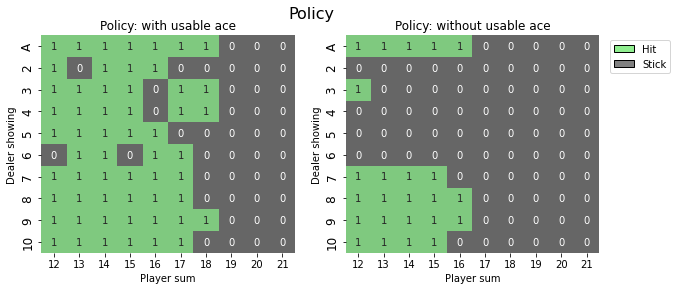

In [ ]:
# policy without\with usable ace (ace counts as 1\11)
policy_grids = []
policy_grids.append(create_grids(Q, usable_ace=True))
policy_grids.append(create_grids(Q, usable_ace=False))
fig1 = create_plots(policy_grids)
plt.show()

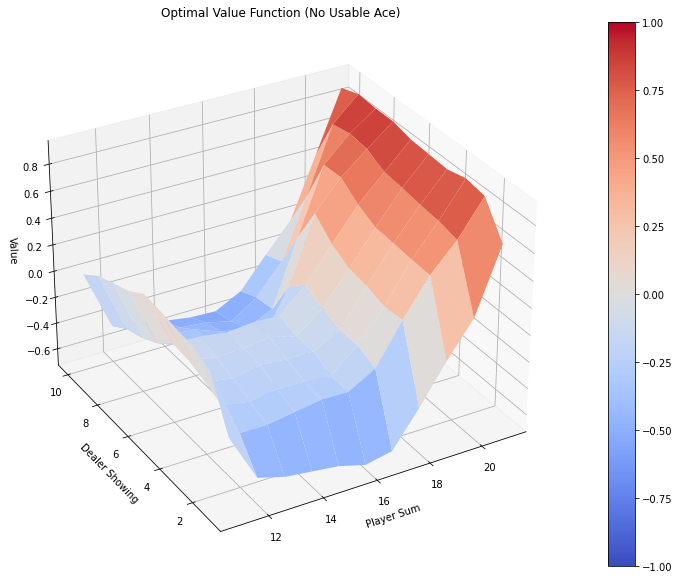

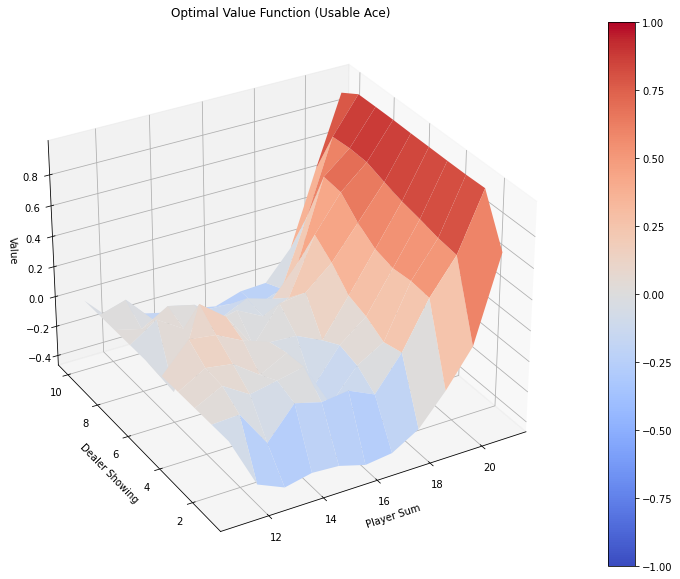

In [ ]:
# value function without\with usable ace (ace counts as 1\11)
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title = 'Optimal Value Function')